In [229]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, jaccard_score
from infomap import Infomap
import numpy as np
import community as community_louvain
import leidenalg as la
import igraph as ig
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist
from sklearn.metrics.cluster import mutual_info_score
from scipy.stats import entropy

def load_network(file_path):
    G = nx.read_pajek(file_path)
    if isinstance(G, nx.DiGraph):
        G = G.to_undirected()
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    return G

def detect_communities(G, method='louvain'):
    if method == 'louvain':
        partition = community_louvain.best_partition(G)
    elif method == 'infomap':
        infomap = Infomap(silent=True)
        for edge in G.edges():
            u, v = map(int, edge)  
            infomap.add_link(u, v)
        infomap.run()
        partition = {int(node): module for node, module in infomap.get_modules().items()}
    elif method == 'agglomerative':
        linkage_matrix = linkage(pdist(nx.to_numpy_array(G)), method='ward')  
        clusters = fcluster(linkage_matrix, 1.5, criterion='distance')
        partition = {node: clusters[i] for i, node in enumerate(G.nodes())}
    elif method == 'leiden':
        ig_graph = ig.Graph.TupleList(G.edges(), directed=False)
        partition = la.find_partition(ig_graph, la.ModularityVertexPartition)
        partition = {node.index: partition.membership[node.index] for node in ig_graph.vs}
    else:
        raise ValueError("Unsupported method: Choose 'louvain' or 'infomap'")
    return partition

def visualize_communities(G, partition, title, show=True):
    if not all(node in partition for node in G.nodes()):
        missing_nodes = [node for node in G.nodes() if node not in partition]
        print(f"Warning: Nodes missing in partition: {missing_nodes}")
        for node in missing_nodes:
            partition[node] = -1  
    
    
    unique_communities = list(set(partition.values()))
    if "Agglomerative" in title:
        community_index = {node: community for node, community in partition.items()}
        colors = [community_index.get(node, 0) for node in G.nodes()]
    else:
        community_index = {comm: idx for idx, comm in enumerate(unique_communities)}
        colors = [community_index[partition[node]] for node in G.nodes()]

    pos = nx.spring_layout(G, seed=42)  

    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = plt.get_cmap('viridis', len(unique_communities))

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, cmap=cmap, node_size=40, alpha=0.8)

    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.05)
    cbar.set_label('Community ID')

    ax.set_title(title)
    ax.axis('off') 
    
    if show:
        plt.show()
        
def compute_modularity_groups(G, partition):
    groups = {}
    for k,v in partition.items():
        if v not in list(groups.keys()):
            groups[v] = {k}
        else:
            groups[v].update([k])

    return nx.community.modularity(G, groups.values()), len(groups)

def mutual_info_variation(true_labels, predicted_labels):
    entropy_true = entropy(np.unique(true_labels, return_counts=True)[1])
    entropy_pred = entropy(np.unique(predicted_labels, return_counts=True)[1])
    mutual_info = mutual_info_score(true_labels, predicted_labels)
    return (entropy_true + entropy_pred - 2 * mutual_info) / (entropy_true + entropy_pred)
    
def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    else:
        return intersection / union

def partition_to_sets(partition):
    from collections import defaultdict
    community_dict = defaultdict(set)
    for node, community in partition.items():
        community_dict[community].add(node)
    return list(community_dict.values())

def compare_communities(community_sets_true, community_sets_computed):
    jaccard_scores = []
    for set_true in community_sets_true:
        max_jaccard = 0
        for set_computed in community_sets_computed:
            score = jaccard_index(set_true, set_computed)
            if score > max_jaccard:
                max_jaccard = score
        jaccard_scores.append(max_jaccard)
    return sum(jaccard_scores) / len(jaccard_scores) if jaccard_scores else 0

def calculate_metrics(true_partition, detected_partition):
    difference = list(set(true_partition.keys()) - set(detected_partition.keys()))
    
    true_labels = [true_partition[node] for node in sorted(true_partition) if node not in difference]
    detected_labels = [detected_partition[node] for node in sorted(detected_partition)]
    
    nmi = normalized_mutual_info_score(true_labels, detected_labels)
#     ari = adjusted_rand_score(true_labels, detected_labels)
    ari = mutual_info_variation(true_labels, detected_labels)
    
    true_sets = partition_to_sets(true_partition)
    computed_sets = partition_to_sets(detected_partition)
    jaccard_idx = compare_communities(true_sets, computed_sets)
    
    return nmi, ari, jaccard_idx

In [230]:
G = load_network('A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.02_prs_0.02.net')
true_partition = {node: node // 60 for node in G.nodes()}  # Example true partition logic
louvain_partition = detect_communities(G, 'louvain')
infomap_partition = detect_communities(G, 'infomap')
ag_partition = detect_communities(G, 'agglomerative')
leiden_partition = detect_communities(G, 'leiden')

nmi_louvain, ari_louvain, ji_louvain = calculate_metrics(true_partition, louvain_partition)
nmi_infomap, ari_infomap, ji_infomap = calculate_metrics(true_partition, infomap_partition)
nmi_ag, ari_ag, ji_ag = calculate_metrics(true_partition, ag_partition)
nmi_leiden, ari_leiden, ji_leiden = calculate_metrics(true_partition, leiden_partition)

print("NMI (Louvain):", nmi_louvain, "NVI (Louvain):", ari_louvain, "JI (Louvain):", ji_louvain)
print("NMI (Infomap):", nmi_infomap, "NVI (Infomap):", ari_infomap, "JI (Informap):", ji_infomap)
print("NMI (Agglomerative):", nmi_infomap, "NVI (Agglomerative):", ari_ag, "JI (Agglomerative):", ji_ag)
print("NMI (Leiden):", nmi_leiden, "NVI (Leiden):", ari_leiden, "JI (Leiden):", ji_leiden)

#visualize_communities(G, louvain_partition, "Louvain Method")
# visualize_communities(G, infomap_partition, "Infomap Method")

NMI (Louvain): 0.03374555904216311 NVI (Louvain): 0.966254440957837 JI (Louvain): 0.10483329535961114
NMI (Infomap): 0.09116291722137045 NVI (Infomap): 0.9088370827786295 JI (Informap): 0.10032609526079823
NMI (Agglomerative): 0.09116291722137045 NVI (Agglomerative): 0.5638076863100496 JI (Agglomerative): 0.016666666666666666
NMI (Leiden): 0.08142717136962101 NVI (Leiden): 0.918572828630379 JI (Leiden): 0.13411230454222117


In [228]:
pd.read_csv('CommunityDetectionResults.csv')

,network,Inf-nmi,Inf-ari,Inf-jaccard,Lou-nmi,Lou-ari,Lou-jaccard,Lei-nmi,Lei-ari,Lei-jaccard,Agg-nmi,Agg-ari,Agg-jaccard
0,synthetic_network_N_300_blocks_5_prr_0.00_prs_...,0.068193,9.318068e-01,0.061899,0.017604,9.823962e-01,0.112586,0.088092,0.911908,0.134255,0.430872,0.569128,0.031894
1,synthetic_network_N_300_blocks_5_prr_0.02_prs_...,0.091163,9.088371e-01,0.100326,0.035126,9.648745e-01,0.113540,0.081987,0.918013,0.159735,0.436192,0.563808,0.016667
2,synthetic_network_N_300_blocks_5_prr_0.04_prs_...,0.110123,8.898774e-01,0.125424,0.054460,9.455396e-01,0.132451,0.067383,0.932617,0.134040,0.439159,0.560841,0.016667
3,synthetic_network_N_300_blocks_5_prr_0.06_prs_...,0.000000,1.000000e+00,0.200000,0.101159,8.988410e-01,0.162753,0.064015,0.935985,0.145364,0.440145,0.559855,0.016667
4,synthetic_network_N_300_blocks_5_prr_0.08_prs_...,0.000000,1.000000e+00,0.200000,0.217733,7.822668e-01,0.269263,0.083404,0.916596,0.163740,0.440145,0.559855,0.016667
5,synthetic_network_N_300_blocks_5_prr_0.10_prs_...,0.000000,1.000000e+00,0.200000,0.330985,6.690146e-01,0.443438,0.075221,0.924779,0.187142,0.440145,0.559855,0.016667
6,synthetic_network_N_300_blocks_5_prr_0.12_prs_...,0.771780,2.282202e-01,0.792973,0.827162,1.728382e-01,0.848568,0.115759,0.884241,0.214719,0.440145,0.559855,0.016667
7,synthetic_network_N_300_blocks_5_prr_0.14_prs_...,0.971252,2.874816e-02,0.980377,0.971252,2.874816e-02,0.980377,0.126939,0.873061,0.223463,0.440145,0.559855,0.016667
8,synthetic_network_N_300_blocks_5_prr_0.16_prs_...,1.000000,-1.379641e-16,1.000000,1.000000,-1.379641e-16,1.000000,0.139349,0.860651,0.233950,0.440145,0.559855,0.016667
9,synthetic_network_N_300_blocks_5_prr_0.18_prs_...,1.000000,-1.379641e-16,1.000000,1.000000,-1.379641e-16,1.000000,0.150383,0.849617,0.241035,0.440145,0.559855,0.016667


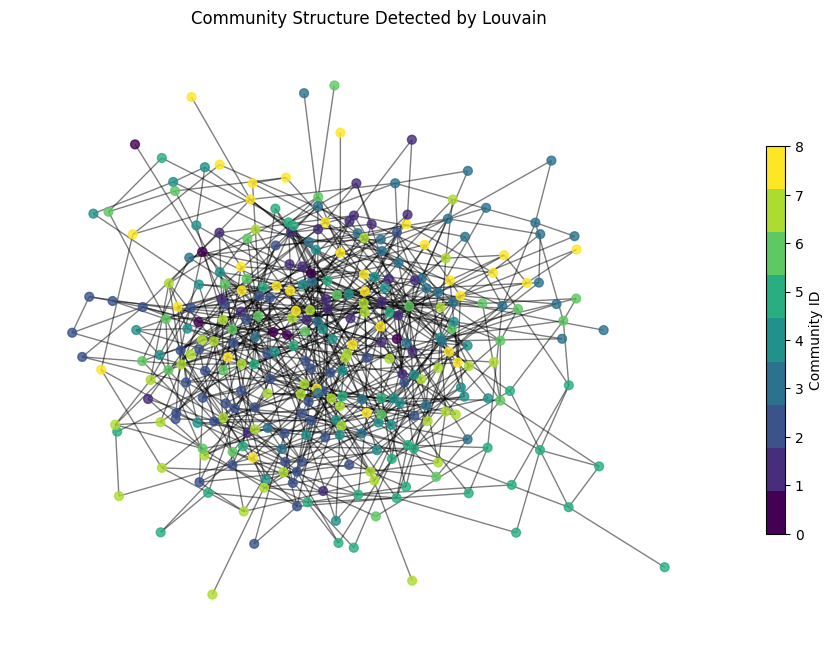

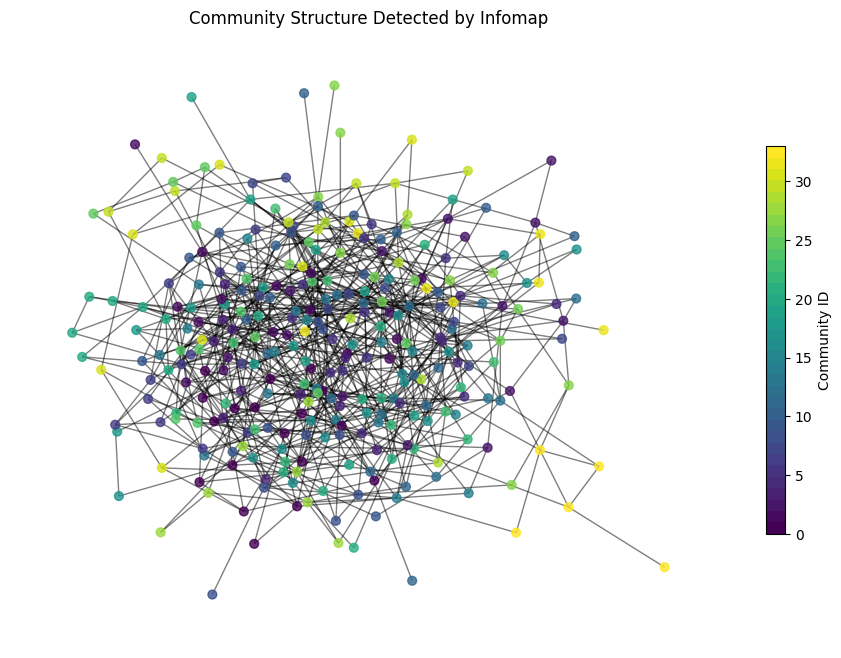

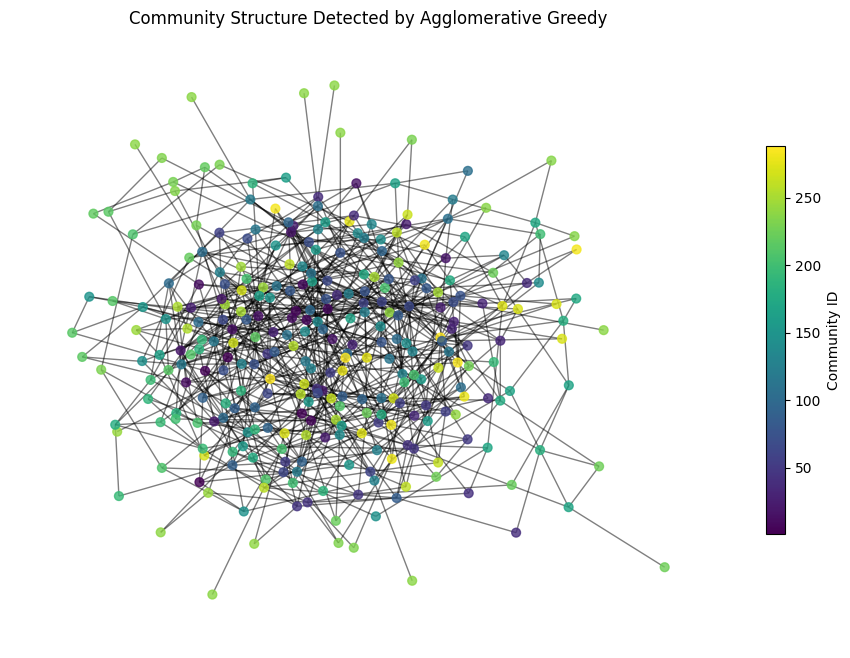

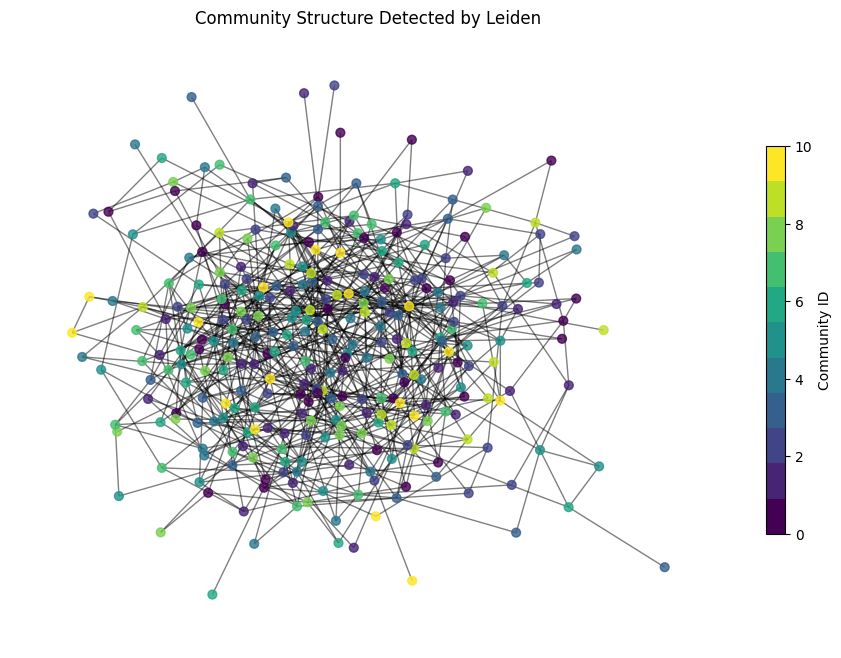

In [10]:
visualize_communities(G, louvain_partition, "Community Structure Detected by Louvain")
visualize_communities(G, infomap_partition, "Community Structure Detected by Infomap")
visualize_communities(G, ag_partition, "Community Structure Detected by Agglomerative Greedy")
visualize_communities(G, leiden_partition, "Community Structure Detected by Leiden")

In [ ]:
import networkx as nx

def girvan_newman_community_detection(G, num_communities=2):
    from networkx.algorithms.community import girvan_newman
    communities_generator = girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    # Choose the level of communities to return based on your num_communities parameter
    if num_communities == 2:
        return {node: idx for idx, community in enumerate(top_level_communities) for node in community}
    else:
        return {node: idx for idx, community in enumerate(next_level_communities) for node in community}

# Example usage
# Adjust num_communities based on how many splits you want to examine initially
gn_partition = girvan_newman_community_detection(G, num_communities=2)
visualize_communities(G, gn_partition, "Community Structure Detected by Girvan-Newman")


In [209]:
from itertools import combinations
def compute_components(true_partition, predicted_partition):
    a = b = c = d = 0
    difference = list(set(true_partition.keys()) - set(detected_partition.keys()))

    # Convert partitions to lists of sets
    def partition_to_clusters(partition):
        cluster_dict = defaultdict(set)
        for node, cluster in partition.items():
            if node not in difference:
                cluster_dict[cluster].add(node)
        return list(cluster_dict.values())

    true_clusters = partition_to_clusters(true_partition)
    predicted_clusters = partition_to_clusters(predicted_partition)

    # Calculate all combinations of nodes for counting
    nodes = list(true_partition.keys())
    for node1, node2 in combinations(nodes, 2):
        if node1 not in difference and node2 not in difference:
            true_same = true_partition[node1] == true_partition[node2]
            pred_same = predicted_partition[node1] == predicted_partition[node2]

            if true_same and pred_same:
                a += 1
            elif true_same and not pred_same:
                b += 1
            elif not true_same and pred_same:
                c += 1
            elif not true_same and not pred_same:
                d += 1

    return a, b, c, d

def jaccard_comp(a,b,c,d):
    return (a/(a+b+c))

In [211]:
a, b, c, d = compute_rand_index_components(true_partition, louvain_partition)
jaccard_comp(*compute_rand_index_components(true_partition, louvain_partition))

0.061647254575707154